# ビットコインの価格予測プログラム

[*********************100%***********************]  1 of 1 completed
SARIMA order: (0, 1, 1), seasonal order: (0, 0, 0, 52)


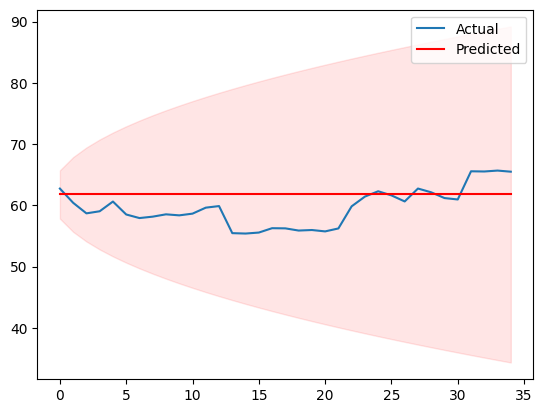

Future 30 week(s) predictions:
Week 1: 61.78 (CI: 57.83, 65.72)
Week 2: 61.78 (CI: 55.67, 67.88)
Week 3: 61.78 (CI: 54.10, 69.45)
Week 4: 61.78 (CI: 52.80, 70.75)
Week 5: 61.78 (CI: 51.66, 71.89)
Week 6: 61.78 (CI: 50.64, 72.91)
Week 7: 61.78 (CI: 49.71, 73.85)
Week 8: 61.78 (CI: 48.84, 74.71)
Week 9: 61.78 (CI: 48.03, 75.52)
Week 10: 61.78 (CI: 47.26, 76.29)
Week 11: 61.78 (CI: 46.53, 77.02)
Week 12: 61.78 (CI: 45.84, 77.72)
Week 13: 61.78 (CI: 45.17, 78.38)
Week 14: 61.78 (CI: 44.53, 79.02)
Week 15: 61.78 (CI: 43.91, 79.64)
Week 16: 61.78 (CI: 43.31, 80.24)
Week 17: 61.78 (CI: 42.74, 80.82)
Week 18: 61.78 (CI: 42.18, 81.38)
Week 19: 61.78 (CI: 41.63, 81.92)
Week 20: 61.78 (CI: 41.10, 82.45)
Week 21: 61.78 (CI: 40.58, 82.97)
Week 22: 61.78 (CI: 40.07, 83.48)
Week 23: 61.78 (CI: 39.58, 83.97)
Week 24: 61.78 (CI: 39.10, 84.45)
Week 25: 61.78 (CI: 38.62, 84.93)
Week 26: 61.78 (CI: 38.16, 85.39)
Week 27: 61.78 (CI: 37.71, 85.85)
Week 28: 61.78 (CI: 37.26, 86.29)
Week 29: 61.78 (CI: 36.82,

In [9]:
import pandas as pd
import yfinance as yf
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox

# データを取得する
def get_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# データの前処理と特徴量エンジニアリングを行う
def preprocess_data(data):
    data = data['Close']
    data = data.resample('W').last()  # 週次データに変換
    data = data.dropna()
    data_boxcox, _ = boxcox(data)  # データの正規化 (Box-Cox変換)
    return data_boxcox

# SARIMAモデルを訓練し、予測を行う
def predict_price(data, steps):
    train, test = train_test_split(data, test_size=0.2)
    model = pm.auto_arima(train, seasonal=True, m=52, suppress_warnings=True, stepwise=True)
    print(f'SARIMA order: {model.order}, seasonal order: {model.seasonal_order}')
    forecasts, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
    future_forecasts, future_conf_int = model.predict(n_periods=steps, return_conf_int=True)
    return forecasts, conf_int, future_forecasts, future_conf_int, test

# プログラムのメイン部分
if __name__ == '__main__':
    ticker = 'BTC-USD'
    start_date = '2020-01-01'
    end_date = '2023-04-09'
    steps = 30

    data = get_data(ticker, start_date, end_date)
    processed_data = preprocess_data(data)
    forecasts, conf_int, future_forecasts, future_conf_int, test = predict_price(processed_data, steps)

    plt.plot(test, label='Actual')
    plt.plot(forecasts, label='Predicted', color='red')
    plt.fill_between(np.arange(0, len(test)), conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='red')
    plt.legend()
    plt.show()

    print(f"Future {steps} week(s) predictions:")
    for i in range(steps):
        print(f"Week {i + 1}: {future_forecasts[i]:.2f} (CI: {future_conf_int[i, 0]:.2f}, {future_conf_int[i, 1]:.2f})")
